In [232]:
import sys
sys.path.append('..')
# import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
lrd_report_fn = 'data/decomposition.tsv'
monomers_fn = "data/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [3]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [160]:
def filter_strings(monomer_strings, max_gap=0.05, max_lowercase=0.01):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        lowercase = [s.islower() for s in string]
        if np.mean(lowercase) > max_lowercase:
            continue
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [161]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

407

In [162]:
def get_frequent_kmers(strings, k, min_mult=5):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, string in strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos


In [390]:
class DeBruijnGraph:
    def __init__(self, k, max_uniq_cov=30):
        self.graph = nx.DiGraph()
        self.k = k
        self.node_mapping = {}
        self.rev_node_mapping = {}
        self.max_uniq_cov = max_uniq_cov

    def add_kmer(self, kmer, coverage=1):
        prefix, suffix = kmer[:-1], kmer[1:]
        
        if prefix in self.node_mapping:
            prefix_node_ind = self.node_mapping[prefix]
        else:
            prefix_node_ind = len(self.node_mapping)
            self.node_mapping[prefix] = prefix_node_ind
            self.rev_node_mapping[prefix_node_ind] = prefix
        
        if suffix in self.node_mapping:
            suffix_node_ind = self.node_mapping[suffix]
        else:
            suffix_node_ind = len(self.node_mapping)
            self.node_mapping[suffix] = suffix_node_ind
            self.rev_node_mapping[suffix_node_ind] = suffix
        
        
        # self.graph.add_edge(prefix, suffix,
        self.graph.add_edge(prefix_node_ind, suffix_node_ind,
                            edge_kmer=kmer,
                            length=self.k,
                            coverages=[coverage],
                            label=f'len={self.k}\ncov={coverage}',
                            color='black' if coverage < self.max_uniq_cov else 'red')

    def add_kmers(self, kmers, coverage=None):
        for kmer in kmers:
            if coverage is None:
                self.add_kmer(kmer)
            else:
                self.add_kmer(kmer, coverage=coverage[kmer])
                
    def index_edges(self, min_k=2):
        all_index = {}
        for k in range(min_k, self.k+1):
            index = defaultdict(list)
            for e_ind, edge in enumerate(self.graph.edges()):
                edge_seq = self.graph.get_edge_data(*edge)['edge_kmer']
                for i in range(len(edge_seq)-k+1):
                    kmer = edge_seq[i:i+k]
                    index[kmer].append((e_ind, i))
            index_unique = {kmer: pos[0]
                            for kmer, pos in index.items()
                            if len(pos) == 1}
            all_index[k] = index_unique
        return all_index
            
    def collapse_nonbranching_paths(self):
        def node_on_nonbranching_path(graph, node):
            return nx.number_of_nodes(graph) > 1 \
                and graph.in_degree(node) == 1 \
                and graph.out_degree(node) == 1

        for node in list(self.graph.nodes()):
            if node_on_nonbranching_path(self.graph, node):
                in_edge = list(self.graph.in_edges(node))[0]
                out_edge = list(self.graph.out_edges(node))[0]
                # in_edge_color = self.graph.edges[in_edge]['color']
                # out_edge_color = self.graph.edges[out_edge]['color']
                in_edge_kmer = self.graph.edges[in_edge]['edge_kmer']
                out_edge_kmer = self.graph.edges[out_edge]['edge_kmer']
                in_edge_cov = self.graph.edges[in_edge]['coverages']
                out_edge_cov = self.graph.edges[out_edge]['coverages']

                in_node = in_edge[0]
                out_node = out_edge[1]

                new_kmer = in_edge_kmer + \
                    out_edge_kmer[-(len(out_edge_kmer)-self.k+1):]
                new_coverages = in_edge_cov + out_edge_cov
                new_coverages.sort()
                new_edge_len = self.k+len(new_coverages)-1
                new_edge_med_cov = np.median(new_coverages)
                self.graph.add_edge(in_node, out_node,
                                    edge_kmer=new_kmer,
                                    coverages=new_coverages,
                                    length=new_edge_len,
                                    label=f'len={new_edge_len}\ncov={new_edge_med_cov}',
                                    color='black' if new_edge_med_cov < self.max_uniq_cov else 'red')
                self.graph.remove_node(node)

    def get_edges(self):
        self.collapse_nonbranching_paths()
        contigs, coverages = [], []
        for edge in self.graph.edges():
            contigs.append(self.graph.get_edge_data(*edge)['edge_kmer'])
            coverages.append(np.median(self.graph.get_edge_data(*edge)['coverages']))
        return contigs, coverages
    
    def get_path(self, list_edges):
        db_edges = list(self.graph.edges())
        path = '' 
        path += self.graph.get_edge_data(*list_edges[0])['edge_kmer']
        for edge in list_edges[1:]:
            new_edge_seq = self.graph.get_edge_data(*edge)['edge_kmer']
            # print(len(path[-(self.k-1):]), path[-(self.k-1):])
            # print(len(new_edge_seq[:self.k-1]), new_edge_seq[:self.k-1])
            assert path[-(self.k-1):] == new_edge_seq[:self.k-1]
            path += new_edge_seq[self.k-1:]
        # path = ''.join(path)
        return path
    
    def get_contigs(self):
        def get_valid_outpaths_from_edge(edge, taken_edges=set()):
            out_node = edge[1]
            out_degree_out_node = self.graph.out_degree(out_node)
            paths = [[edge]]
            if out_degree_out_node == 1:
                out_edge = list(self.graph.out_edges(out_node))[0]
                if out_edge not in taken_edges:
                    passed_taken_edges = taken_edges.copy()
                    passed_taken_edges.add(edge)
                    paths = get_valid_outpaths_from_edge(out_edge,
                                                         taken_edges=passed_taken_edges)
                    paths = paths.copy()
                    for i in range(len(paths)):
                        paths[i].append(edge)
            
            return paths
        
        def get_valid_inpaths_from_edge(edge, taken_edges=set()):
            in_node = edge[0]
            in_degree_in_node = self.graph.in_degree(in_node)
            
            paths = [[edge]]
            if in_degree_in_node == 1:
                in_edge = list(self.graph.in_edges(in_node))[0]
                if in_edge not in taken_edges:
                    passed_taken_edges = taken_edges.copy()
                    passed_taken_edges.add(edge)
                    paths = get_valid_inpaths_from_edge(in_edge,
                                                        taken_edges=passed_taken_edges)
                    paths = paths.copy()
                    for i in range(len(paths)):
                        paths[i].append(edge)
            return paths
        
        # Getting valid in- and out-paths for each edge
        edge_outpaths, edge_inpaths = {}, {}
        for edge in self.graph.edges():
            edge_outpaths[edge] = get_valid_outpaths_from_edge(edge)
            edge_inpaths[edge] = get_valid_inpaths_from_edge(edge)
        for edge in self.graph.edges():
            edge_inpaths[edge] = [tuple(path) for path in edge_inpaths[edge]]
            edge_outpaths[edge] = [tuple(path[::-1]) for path in edge_outpaths[edge]]
        
        # Unite all such paths and delete duplicates
        all_paths = []
        for edge in self.graph.edges():
            all_paths += edge_inpaths[edge] + edge_outpaths[edge]
        all_paths = list(set(all_paths))
        
        # Select only paths that are not a subpath of other paths
        selected_paths = []
        for path1 in all_paths:
            has_duplicate = False
            for path2 in all_paths:
                if path1 == path2:
                    continue
                for i in range(len(path2)-len(path1)+1):
                    if path1 == path2[i:i+len(path1)]:
                        has_duplicate = True
                        break
                if has_duplicate:
                    break
            if not has_duplicate:
                selected_paths.append(path1)
        
        # check that all edges of that graph are incorporated in selected paths
        edges_in_selected_paths = []
        for path in selected_paths:
            edges_in_selected_paths += path
        assert len(set(self.graph.edges()) - set(edges_in_selected_paths)) == 0
        
        contigs = []
        for path in selected_paths:
            contigs.append(self.get_path(path))
        return contigs, selected_paths

In [373]:
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=300, min_mult=7)
db = DeBruijnGraph(k=300)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)
db.collapse_nonbranching_paths()

In [374]:
# db.get_valid_paths()

In [375]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [376]:
for cc in nx.weakly_connected_components(db.graph):
    print(len(cc))
    print([db.rev_node_mapping[node] for node in cc])

30
['JKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRAB', 'DEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMN', 'FGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOP', 'GHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRAB

In [395]:
def iterative_graph(monomer_strings, min_k, max_k, min_mult=5, step=1, starting_graph=None):
    dbs, all_contigs = {}, {}
    input_strings = monomer_strings.copy()
    
    if starting_graph is not None:
        contigs, contig_paths = starting_graph.get_contigs()
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{min_k}_i{i}_j{j}'] = contigs[i]

    for k in range(min_k, max_k+1, step):
        print(f'\nk={k}')
        # print(len(input_strings))
        frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(input_strings, k=k, min_mult=min_mult)
        print(f'#frequent kmers = {len(frequent_kmers)}')
        db = DeBruijnGraph(k=k)
        db.add_kmers(frequent_kmers, coverage=frequent_kmers)

        # lens = sorted((len(contig), coverage) for contig, coverage in zip(contigs, coverages))[::-1]
        # long_edges = [x for x in lens if x[1] >= 50]
        db.collapse_nonbranching_paths()
        if nx.number_weakly_connected_components(db.graph) > 1:
            print(f'#cc = {nx.number_weakly_connected_components(db.graph)}')
            for cc in nx.weakly_connected_components(db.graph):
                print(len(cc))
            # break
        dbs[k] = db

        contigs, contig_paths = db.get_contigs()
        all_contigs[k] = contigs

        input_strings = monomer_strings.copy()
        # print(len(input_strings))
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{k}_i{i}_j{j}'] = contigs[i]
        # print(len(input_strings))
    
    return all_contigs, dbs

In [404]:
min_k, max_k = 70, 500
contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)


k=70
#frequent kmers = 1229

k=71
#frequent kmers = 1261

k=72
#frequent kmers = 1294

k=73
#frequent kmers = 1327

k=74
#frequent kmers = 1360

k=75
#frequent kmers = 1393

k=76
#frequent kmers = 1425

k=77
#frequent kmers = 1458

k=78
#frequent kmers = 1491

k=79
#frequent kmers = 1524

k=80
#frequent kmers = 1561

k=81
#frequent kmers = 1598

k=82
#frequent kmers = 1635

k=83
#frequent kmers = 1678

k=84
#frequent kmers = 1721

k=85
#frequent kmers = 1764

k=86
#frequent kmers = 1810

k=87
#frequent kmers = 1856

k=88
#frequent kmers = 1900

k=89
#frequent kmers = 1945

k=90
#frequent kmers = 1991

k=91
#frequent kmers = 2037

k=92
#frequent kmers = 2084

k=93
#frequent kmers = 2131

k=94
#frequent kmers = 2178

k=95
#frequent kmers = 2228

k=96
#frequent kmers = 2278

k=97
#frequent kmers = 2328

k=98
#frequent kmers = 2386

k=99
#frequent kmers = 2444

k=100
#frequent kmers = 2502

k=101
#frequent kmers = 2569

k=102
#frequent kmers = 2636

k=103
#frequent kmers = 2703

k=104
#fr

#frequent kmers = 13859

k=307
#frequent kmers = 13878

k=308
#frequent kmers = 13897

k=309
#frequent kmers = 13916

k=310
#frequent kmers = 13935

k=311
#frequent kmers = 13954

k=312
#frequent kmers = 13973

k=313
#frequent kmers = 13992

k=314
#frequent kmers = 14011

k=315
#frequent kmers = 14030

k=316
#frequent kmers = 14049

k=317
#frequent kmers = 14068

k=318
#frequent kmers = 14087

k=319
#frequent kmers = 14106

k=320
#frequent kmers = 14125

k=321
#frequent kmers = 14144

k=322
#frequent kmers = 14161

k=323
#frequent kmers = 14178

k=324
#frequent kmers = 14195

k=325
#frequent kmers = 14212

k=326
#frequent kmers = 14229

k=327
#frequent kmers = 14246

k=328
#frequent kmers = 14263

k=329
#frequent kmers = 14280

k=330
#frequent kmers = 14297

k=331
#frequent kmers = 14314

k=332
#frequent kmers = 14331

k=333
#frequent kmers = 14348

k=334
#frequent kmers = 14365

k=335
#frequent kmers = 14380

k=336
#frequent kmers = 14395

k=337
#frequent kmers = 14410

k=338
#frequen

In [410]:
# db = dbs[max(dbs.keys())]
db = dbs[463]
assert nx.number_weakly_connected_components(db.graph) == 1

In [411]:
contigs, contig_paths = db.get_contigs()

In [412]:
total_length = 0
for contig in contigs:
    total_length += len(contig)
    print(len(contig))
# print(total_length)

480
477
621
1440
1068
495
906
2707
1890
909
582
855
2580
2793
594
1167
909
1746
1056
1156
4020
3797
3779
1356
480
1082
660
1582
1071
868
495
482
1349
2010
989
723
1047
2010
2196
2217
480
2705


In [413]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [414]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [418]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges())
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

In [419]:
mapping = map_reads(monomer_strings, db)

In [420]:
print(np.mean([read_mapping is not None for read_mapping in mapping.values()]))
print(np.mean([read_mapping[2] for read_mapping in mapping.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mapping.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.7051597051597052
0.89198606271777
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1423 ((18, 153), (18, 372), True, [(3783, 6837)])
01f80610-395e-4ef8-93d0-526989b8cb53 1214 207594 2456 ((38, 734), (42, 256), True, [(9710, 11229), (11229, 7346)])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 837 143127 1704 ((39, 625), (39, 961), True, [(9710, 13497)])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 1704 ((39, 269), (39, 447), True, [(9710, 13497)])
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1032 176472 2445 ((48, 376), (0, 218), True, [(14459, 1100), (1100, 9358)])
05c5a912-42ad-4a57-ae81-0a318dc8c6b7 865 147915 1994 ((0, 733), (0, 840), True, [(1100, 9358)])
079aa8c8-90a4-4fe8-af37-d9170f7d82b7 983 168093 1686 ((38, 228), (38, 742), True, [(9710, 11229)])
08a68948-5d96-4ed2-9632-c86d0200d914 1071 183141 1187 ((33, 8), (4, 307), True, [(8418, 1975), (1975, 2125), (2125, 2236), (2236, 8598)])
0b1f944b-90f7-4e17-a1cd-f02d38d0f84c 649 110979 1147 ((47, 11), (11, 41), True, [(14048, 2852), (2852, 2885

# Matrix of connections

In [184]:
def select_rare_edges(db, max_cov=30):
    contigs, coverages = db.get_contigs()
    return [i for i in range(len(coverages)) if coverages[i] <= max_cov]

In [185]:
rare_edges = select_rare_edges(db)
# rare_edges_index = {rare_edges[i]: i for i in range(len(rare_edges))}

In [186]:
def get_distance_matrix(db, mapping, rare_edges):
    distances = defaultdict(list)
    rare_edges = set(rare_edges)
    for r_id, read_mapping in mapping.items():
        if read_mapping is not None and read_mapping[2]:
            edge_path = read_mapping[-1]
            is_rare = [i for i, edge in enumerate(edge_path) if edge in rare_edges]
            # print(is_rare)
            for i, j in zip(is_rare[:-1], is_rare[1:]):
                if j - i <= 0:
                    continue
                # print(edge_path[i], edge_path[j])
                distances[(edge_path[i], edge_path[j])].append(
                    (j-i, tuple(edge_path[i:j+1]))
                )
           # for i, e1 in enumerate(edge_path):
           #     if e1 not in rare_edges:
           #         continue
           #     for j, e2 in enumerate(edge_path):
           #         if j - i <= 1 or e2 not in rare_edges:
           #             continue
           #         edge_subpath = edge_path[i:j+1]
           #         subpath = db.get_path(edge_subpath)
                    # distances[e1][e2].append(len(subpath))
           #         distances[(e1, e2)].append(len(edge_subpath) - 1)
    filtered_distances = {}
    for (e1, e2), dist in distances.items():
        if len(Counter(dist)) == 1 and len(dist) > 1:
            print("")
            dist = dist[0]
            print((e1, e2), dist)
            edges = list(db.graph.edges())
            for edge in dist[1]:
                print(edge, edges[edge])
            path = db.get_path(dist[1])
            filtered_distances[(e1, e2)] = (dist[0], len(path))
    return filtered_distances

In [187]:
distances = get_distance_matrix(db, mapping, rare_edges=rare_edges)
distances


(1, 0) (1, (1, 0))
1 (1955, 1823)
0 (1823, 4306)

(23, 1) (1, (23, 1))
23 (3915, 1955)
1 (1955, 1823)

(13, 15) (1, (13, 15))
13 (3248, 3254)
15 (3254, 3509)

(15, 16) (1, (15, 16))
15 (3254, 3509)
16 (3509, 3812)

(16, 18) (1, (16, 18))
16 (3509, 3812)
18 (3812, 1823)

(8, 23) (1, (8, 23))
8 (3110, 3915)
23 (3915, 1955)

(34, 10) (23, (34, 20, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 6, 7, 10))
34 (9362, 3868)
20 (3868, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
6 (3091, 3110)
7 (3110, 3128)
10 (3128, 5002)

(18, 0) (1, (18, 0))
18 (3812, 1823)
0 (1823, 4306)

(26, 21) (2, (26, 19, 21))
26 (4572, 3853)
19 (3853, 3868)
21 (3868, 4557)

(21, 25) (1, (21, 25))
21 (3868, 4557)
25 (4557, 4572)

(25, 27) (1, (25, 27))
25 (4557, 45

{(0, 13): (15, 636),
 (1, 0): (1, 1886),
 (8, 22): (1, 336),
 (8, 23): (1, 1492),
 (10, 28): (1, 546),
 (12, 40): (1, 1274),
 (13, 15): (1, 579),
 (14, 31): (1, 720),
 (14, 32): (1, 1037),
 (15, 16): (1, 876),
 (15, 17): (1, 648),
 (16, 18): (1, 687),
 (17, 28): (1, 441),
 (18, 0): (1, 420),
 (21, 25): (1, 366),
 (22, 25): (1, 336),
 (23, 1): (1, 3009),
 (25, 26): (1, 603),
 (25, 27): (1, 996),
 (26, 21): (2, 636),
 (27, 33): (1, 999),
 (28, 29): (1, 531),
 (28, 30): (1, 1550),
 (29, 18): (1, 549),
 (31, 15): (1, 924),
 (33, 34): (1, 390),
 (33, 35): (1, 1389),
 (34, 10): (23, 729),
 (34, 12): (15, 561),
 (35, 37): (1, 1582),
 (35, 38): (1, 1915),
 (38, 39): (1, 1968),
 (39, 8): (21, 1631),
 (40, 33): (1, 1259),
 (42, 39): (1, 1648)}

In [188]:
distance_graph = nx.DiGraph()
for (e1, e2), dist in distances.items():
    distance_graph.add_edge(e1, e2, label=dist[1])

In [189]:
nx.drawing.nx_pydot.write_dot(distance_graph, 'distance_graph.dot')

In [190]:
nx.is_directed_acyclic_graph(distance_graph)

False

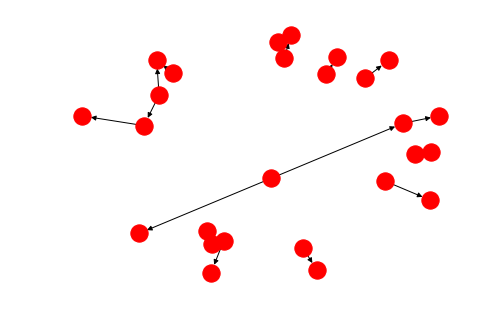

In [137]:
nx.draw(distance_graph)

In [382]:
nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(distance_graph)

nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

Generating CX


'http://public.ndexbio.org/v2/network/e70d7bdd-ff83-11e9-bb65-0ac135e8bacf'